In [1]:
import numpy as np
import pandas as pd
import glob
import os
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Initial Functions

In [2]:
#transform standings from Julien's CSV to standings with CP
def fill_reg_CP(row, df):
    if row.name == 1:
        return 200
    elif row.name == 2:
        return 160
    elif row.name == 3 or row.name == 4:
        return 130
    elif 5 <= row.name <= 8:
        return 100
    elif 9 <= row.name <= 16:
        if len(df['Player_Name']) >= 48:
            return 80
        else:
            return 0
    elif 17 <= row.name <= 32:
        if len(df['Player_Name']) >= 100:
            return 60
        else:
            return 0
    elif 33 <= row.name <= 64:
        if len(df['Player_Name']) >= 200:
            return 50
        else:
            return 0
    elif 65 <= row.name <= 128:
        if len(df['Player_Name']) >= 400:
            return 40
        else:
            return 0
    elif 129 <= row.name <= 256:
        if len(df['Player_Name']) >= 800:
            return 30
        else:
            return 0
    else:
        return 0

def fill_IC_CP(row, df):
    if row.name == 1:
        return 500
    elif row.name == 2:
        return 400
    elif row.name == 3 or row.name == 4:
        return 320
    elif 5 <= row.name <= 8:
        return 250
    elif 9 <= row.name <= 16:
        if len(df['Player_Name']) >= 48:
            return 200
        else:
            return 0
    elif 17 <= row.name <= 32:
        if len(df['Player_Name']) >= 100:
            return 160
        else:
            return 0
    elif 33 <= row.name <= 64:
        if len(df['Player_Name']) >= 200:
            return 130
        else:
            return 0
    elif 65 <= row.name <= 128:
        if len(df['Player_Name']) >= 400:
            return 100
        else:
            return 0
    elif 129 <= row.name <= 256:
        if len(df['Player_Name']) >= 800:
            return 80
        else:
            return 0
    elif 257 <= row.name <= 512:
        if len(df['Player_Name']) >= 1600:
            return 60
        else:
            return 0
    else:
        return 0

def transform_standings(csv):
    # Get the current column names
    df = pd.read_csv(csv)
    column_names = df.columns.tolist()

    # Replace the name of the first column
    column_names[0] = 'Player_Name'

    # Assign the modified column names back to the DataFrame
    df.columns = column_names

    # Delete everything but Player Name
    df['Player_Name'] = df['Player_Name'].str.partition('\t')[0]

    # Drop duplicates
    df = df.drop_duplicates(subset='Player_Name')
    
    #chops off the country from the names here if it exists
    df['Player_Name'] = df['Player_Name'].apply(lambda x: x[:-5] if x.endswith("]") else x) 

    #reset indices and gives actual placement
    df.reset_index(drop=True, inplace=True)
    df.index += 1

    #apply CP function
    file_name = os.path.basename(csv)
    
    column_name = file_name[:-4]
    
    if file_name[2:4]=='IC':
        df[column_name] = df.apply(fill_IC_CP, args=(df,), axis=1)
    else: 
        df[column_name] = df.apply(fill_reg_CP, args=(df,), axis=1)
    return df


#Make any regionals/IC CP database, takes in the path folder and what to name this dataframe
def make_playerCP_database(path, name_database):
    #read all tournament data from the Championship Analysis Folder
    
    files = glob.glob(path)
    all_tournaments = []
    for f in files:
        transformed_df = transform_standings(f)
        all_tournaments.append(transformed_df)

    #merge all tournaments together
    name_database = pd.merge(all_tournaments[0], all_tournaments[1], on='Player_Name', how='outer')
    for i in range(2, len(all_tournaments)):
        name_database = pd.merge(name_database, all_tournaments[i], on='Player_Name', how='outer')
    
    #count number of events not played and played  
    name_database['num_events_not_played'] = name_database.apply(lambda row: row.isna().sum(), axis=1)
    name_database['number_events_played'] = len(all_tournaments) - name_database['num_events_not_played']
    name_database = name_database.drop('num_events_not_played', axis=1)
    
    name_database['Total_CP']=name_database.iloc[:,1:-1].sum(axis=1)
    
    #Best Finish Limit of 6 
    def sum_six_largest(row):
         return row.nlargest(6).sum()

     # Apply the function to each row and store the result as a new column
    name_database['BFL_CP'] = name_database.iloc[:, 1:-2].apply(sum_six_largest, axis=1)
    
    return name_database

# Import, Merge, and Clean Data

In [3]:
#Regional Championships + SPEs Data

reg_spe = r'/Users/horacemann/All Python Projects/Championship Point Analysis/Regionals/*.csv'
regionals_spes = pd.DataFrame()
regionals_spes = make_playerCP_database(reg_spe, regionals_spes)
regionals_spes = regionals_spes.rename(columns = 
         {'number_events_played' : 'number_regs_played', 'Total_CP' : 'Regs_CP', 'BFL_CP' : 'Regs_BFL_CP'})

#ICs Data
IC = r'/Users/horacemann/All Python Projects/Championship Point Analysis/ICs/*.csv'
Internationals = pd.DataFrame()
Internationals = make_playerCP_database(IC, Internationals)
Internationals.drop('BFL_CP', axis=1, inplace=True)
Internationals = Internationals.rename(columns = 
        {'number_events_played' : 'number_ICs_played', 'Total_CP': 'IC_CP'})

In [4]:
#Merge Regionals and ICs data
ICs_regionals_spes = pd.merge(regionals_spes, Internationals, on='Player_Name', how='outer')

#make every name in the format "Mike Fouchet"
ICs_regionals_spes['Player_Name'] = [name.title() for name in ICs_regionals_spes['Player_Name']]

#stupid Grant Shen
ICs_regionals_spes['Player_Name'].replace("💯Gshen💯 💯Nucci💯","Grant Shen",inplace=True)

#strip any non-alphabetic symbols
ICs_regionals_spes['Player_Name'] = ICs_regionals_spes['Player_Name'].str.replace('[^a-zA-Z]', '', regex=True)

#combine any players that now have two rows
ICs_regionals_spes = ICs_regionals_spes.groupby('Player_Name').sum(min_count=1).reset_index()

ICs_regionals_spes['Majors_CP'] = ICs_regionals_spes['Regs_BFL_CP'] + ICs_regionals_spes['IC_CP']

In [5]:
#Take Leaderboard standings from Julien
# URL of the JSON data
url = 'https://pokedata.ovh/worlds/leaderboards.json'

# Fetch the JSON data from the URL
response = requests.get(url)

# Convert the JSON data to a Python dictionary
player_data = response.json()

#filter to masters and TCG players
filtered_players = [player for player in player_data if player.get('product') == 'tcg' and player.get('league') == 'master']

#get most recent points
for player in filtered_players:
# Extract the 'points' list
    points_list = player['points']

    # Sort the 'points' list by date
    sorted_points = sorted(points_list, key=lambda x: datetime.datetime.fromisoformat(x['date']))

    # Get the 'points' value from the last entry in the sorted list
    latest_points = sorted_points[-1]['points']

    # Update the 'points' key to store only the latest number
    player['points'] = latest_points



In [6]:
#convert leaderboard data and clean into a DataFrame
CP_standings = pd.DataFrame(filtered_players)
CP_standings = CP_standings.drop(['product', 'league'], axis=1)
CP_standings.sort_values(by='points', ascending=False)
CP_standings['name'] = [name.title() for name in CP_standings['name']]
CP_standings['name'] = CP_standings['name'].str.replace('[^a-zA-Z]', '', regex=True)
#CP_standings = CP_standings.drop_duplicates(subset=['name'], keep='last')



# Attempting to solve the name problem

In [1]:
#Figuring out who matches their names in my database and the leaderboard
db1 = ICs_regionals_spes['Player_Name'].copy()
db2 = CP_standings['name'].copy()

# Merge
merged = pd.merge(db1, db2, how='outer', left_on='Player_Name', right_on='name', indicator=True)
merged = merged.loc[~((merged['Player_Name'] == '0') & (merged['name'] == '0'))]

# Find rows that don't have a match
matched = merged[merged['_merge'] == 'both']
no_match = merged[merged['_merge'] != 'both']

no_match['Player_Name'].fillna('0', inplace=True)
no_match['name'].fillna('0', inplace=True)


NameError: name 'ICs_regionals_spes' is not defined

In [8]:
# ##dealing with different names in Leaderboard standings vs my standings using fuzzy

# from rapidfuzz import fuzz, process
# from collections import defaultdict


# # Sample data
# db1 = no_match.loc[no_match['Player_Name'] != '0', 'Player_Name'].tolist()
# db2 = no_match.loc[no_match['name'] != '0', 'name'].tolist()

# # Blocking: group names by the first letter
# blocks_db1 = defaultdict(list)
# blocks_db2 = defaultdict(list)

# for name in db1:
#     initial = name[0].upper()  # use the first letter as the block key
#     blocks_db1[initial].append(name)

# for name in db2:
#     initial = name[0].upper()  # use the first letter as the block key
#     blocks_db2[initial].append(name)

# # Fuzzy matching within blocks
# threshold = 90  # similarity score threshold
# matches = []

# for block_key in blocks_db1:
#     if block_key in blocks_db2:
#         names_db1 = blocks_db1[block_key]
#         names_db2 = blocks_db2[block_key]
        
#         for name1 in names_db1:
#             # For each name in db1, find the best match in db2 within the same block
#             result = process.extractOne(name1, names_db2, scorer=fuzz.ratio)
#             if result:  # Check if a result was found
#                 match, score, index = result
#                 if score > threshold:
#                     matches.append((name1, match))


# matches_df = pd.DataFrame(matches, columns=['Player_Name', 'Leaderboard_name'])
# matches_df.to_excel('output.xlsx', index=False)

# # Merge Leaderboard table and matches
# new_leaderboard = pd.merge(CP_standings, matches_df, left_on='name', right_on='Leaderboard_name', how='outer')

# # Replace the names in new_leaderboard with new names where they exist
# new_leaderboard['name'] = new_leaderboard['Player_Name'].combine_first(new_leaderboard['name'])

# new_leaderboard.drop(columns=['Player_Name', "Leaderboard_name"], inplace=True)

In [28]:
new_leaderboard=CP_standings

# Merge Leaderboard and Regional/IC data as best I can

In [29]:
final_standings = ICs_regionals_spes.merge(new_leaderboard, left_on='Player_Name', right_on='name', how='outer')
final_standings['Player_Name'] = final_standings['Player_Name'].combine_first(final_standings['name'])
final_standings.drop(columns=['name'], inplace=True)
#calculate CP from Locals
final_standings['Local_Events_CP'] = final_standings['points'] - final_standings['Majors_CP']

#get rid of negative point values
final_standings['Local_Events_CP']=final_standings['Local_Events_CP'].apply(lambda x: 0 if x<0 else x)


#simpler combine any players that now have two rows
#final_standings = final_standings.groupby('Player_Name').sum().reset_index()

#custom aggregate function so I can preserve the country/regions columns
def custom_agg(x):
    agg = x.sum(min_count=1) if np.issubdtype(x.dtype, np.number) else x.iloc[0]
    return agg

# Group by 'Player_Name' and apply the custom aggregation function
final_standings = final_standings.groupby('Player_Name').agg(custom_agg).reset_index()
final_standings['Total_Points'] = final_standings[['Majors_CP', 'points']].max(axis=1)
final_standings.drop('points', axis=1, inplace=True)

#rearrange columns
new_cols = ['Player_Name', 'country', 'region',
 'san diego', 'utrecht', 'charlotte', 'toronto', 'stuttgart', 'warsaw', 'knoxville', 'sydney', 'bilbao',
 'puerto rico', 'liverpool', 'torino', 'buenos aires', 'bogota', 'vancouver', 'lille', 'salt lake city',
 'peoria','orlando','arlington','bochum','milwaukee','natal','perth','lima','fresno','fort wayne',
 'santiago','malmo','baltimore','sao paulo','london_open1','portland','london_open2','brisbane','porto alegre',
    'hartford','OCIC','LAIC','NAIC','EUIC',
 'number_regs_played','Regs_CP','Regs_BFL_CP','number_ICs_played','IC_CP','Majors_CP','Local_Events_CP','Total_Points']

final_standings = final_standings[new_cols]



# Experimenting

In [30]:
#ICs_regionals_spes[ICs_regionals_spes['Player_Name']=="AlanRosewicz"]
#CP_standings[CP_standings['country']=="NLD"]
#final_standings.loc[400:405]
final_standings[final_standings['Player_Name']=="MikeFouchet"]

,Player_Name,country,region,san diego,utrecht,charlotte,toronto,stuttgart,warsaw,knoxville,...,NAIC,EUIC,number_regs_played,Regs_CP,Regs_BFL_CP,number_ICs_played,IC_CP,Majors_CP,Local_Events_CP,Total_Points
13818,MikeFouchet,USA,NA,NaN,NaN,NaN,30.0,NaN,NaN,NaN,...,60.0,0.0,6.0,220.0,220.0,2.0,60.0,280.0,120.0,400.0


In [12]:
#Next Steps: 

#Test this:
#name_database['num_events_got_points'] = name_database.apply(lambda row: row.np.count_nonzero(name_database, axis=1)
    #then adjust sums in function if necessary

#look at all players that have a negative local events CP and 
#that will tell me some more people that can be matched up

#give possible cup/challenge combos based on the locals CP amount

#other visualizations?

#include other overarching stats somewhere, like wasted CP and total CP

#be able to filter statistics based on certain thresholds. ex. average # of events played for worlds invitees

#what other things can I calculate? 
    #CP to regs and CP to IC point ratios
        #how many top 16 NA players are also in top 16 most played, top 16 of regs/ICs per regs/IC
    #show BFLs and tourneys played (will need to go into the data to figure that out) for each person

In [13]:
#assign Cup/Challenge combinations based on remaining local points

from itertools import product

def find_combinations(group1, group2, target):
    # Generate all possible combinations of exactly 2 elements from each group
    options1 = [(a + b, sorted([a, b])) for a, b in product(group1, group1) if a <= b]
    options2 = [(a + b, sorted([a, b])) for a, b in product(group2, group2) if a <= b]
    
    # Find combinations that sum up to the target
    results = []
    for sum1, nums1 in options1:
        for sum2, nums2 in options2:
            if sum1 + sum2 == target:
                results.append((nums1, nums2))
    return results

# Example
group1 = [0, 25, 32, 50]
group2 = [0, 10, 12, 15]
target = 80
print(find_combinations(group1, group2, target))


[([0, 50], [15, 15]), ([25, 25], [15, 15])]


# Analysis

In [31]:
#Break database into summary statistics and individual tourney points
summary_results = final_standings[['Player_Name', 'country', 'region','number_regs_played', 
                                   'Regs_CP', 'Regs_BFL_CP', 'number_ICs_played', 'IC_CP', 
                                   'Majors_CP', 'Local_Events_CP', 'Total_Points']]
tourney_results = final_standings.drop(['country', 'region','number_regs_played', 
                                   'Regs_CP', 'Regs_BFL_CP', 'number_ICs_played', 'IC_CP', 
                                   'Majors_CP', 'Local_Events_CP', 'Total_Points'], axis=1)

summary_results['regs_point_ratio'] = summary_results['Regs_CP'] / summary_results['number_regs_played']
summary_results['regs_BFL_point_ratio'] = summary_results['Regs_BFL_CP'] / summary_results['number_regs_played']
summary_results['IC_point_ratio'] = summary_results['IC_CP'] / summary_results['number_ICs_played']


<ipython-input-31-62c4b8a5078e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_results['regs_point_ratio'] = summary_results['Regs_CP'] / summary_results['number_regs_played']
<ipython-input-31-62c4b8a5078e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_results['regs_BFL_point_ratio'] = summary_results['Regs_BFL_CP'] / summary_results['number_regs_played']
<ipython-input-31-62c4b8a5078e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [32]:
#highest point ratios
summary_results[summary_results['number_regs_played']>3].sort_values(by='regs_BFL_point_ratio', ascending=False).head()

#highest number of regs played
#summary_results.sort_values('number_regs_played', ascending=False).head(20)


,Player_Name,country,region,number_regs_played,Regs_CP,Regs_BFL_CP,number_ICs_played,IC_CP,Majors_CP,Local_Events_CP,Total_Points,regs_point_ratio,regs_BFL_point_ratio,IC_point_ratio
19233,WilliamAzevedo,BRA,LA,5.0,520.0,520.0,2.0,360.0,880.0,130.0,1010.0,104.0,104.0,180.0
13905,MioszDyrlica,POL,EU,5.0,510.0,510.0,1.0,80.0,590.0,120.0,710.0,102.0,102.0,80.0
15207,PedroPertusi,BRA,LA,5.0,510.0,510.0,4.0,810.0,1320.0,113.0,1433.0,102.0,102.0,202.5
1210,AndrewHedrick,NaN,NaN,10.0,1050.0,890.0,2.0,160.0,1050.0,NaN,1050.0,105.0,89.0,80.0
2657,BrentTonisson,AUS,AP,4.0,350.0,350.0,4.0,500.0,850.0,102.0,952.0,87.5,87.5,125.0


In [33]:
CP_standings['points'].groupby(CP_standings['region']).mean()

region
AP    95.243816
EU    63.433984
LA    66.082335
NA    66.561827
Name: points, dtype: float64

In [34]:
#interesting overall statistics

wasted_reg_CP = final_standings['Regs_CP'].sum() - final_standings['Regs_BFL_CP'].sum()
print(wasted_reg_CP)

total_CP = final_standings['Total_Points'].sum()
print(total_CP)

7490.0
687569.0


In [35]:
#Leaderboard statistics and invites
average_CP_by_region = CP_standings.groupby('region')['points'].mean()
num_players_with_CP_by_region = CP_standings['name'].groupby(CP_standings['region']).count()
num_NA_invites = CP_standings['name'][(CP_standings['region']=='NA') & (CP_standings['points']>=350)].count()
num_EU_invites = CP_standings['name'][(CP_standings['region']=='EU') & (CP_standings['points']>=250)].count()
num_LA_invites = CP_standings['name'][(CP_standings['region']=='LA') & (CP_standings['points']>=250)].count()
num_AP_invites = CP_standings['name'][(CP_standings['region']=='AP') & (CP_standings['points']>=200)].count()
TPCi_invites = num_NA_invites + num_EU_invites + num_LA_invites + num_AP_invites


region_data = final_standings.groupby('region')['Total_Points'].sum()
region_data = pd.DataFrame(region_data)
region_data.rename(columns={'Total_Points':'total_CP'},inplace=True)
region_data['number_players_with_CP']=num_players_with_CP_by_region
region_data['average_CP_per_player'] = average_CP_by_region
region_data['percent_global_CP']=region_data['total_CP'] / region_data['total_CP'].sum() * 100
region_data['number_of_invites'] = [num_AP_invites, num_EU_invites, num_LA_invites, num_NA_invites]
region_data['day2_invites'] = [4, 22, 12, 16]
region_data['day1_invites'] = region_data['number_of_invites'] - region_data['day2_invites']
region_data

,total_CP,number_players_with_CP,average_CP_per_player,percent_global_CP,number_of_invites,day2_invites,day1_invites
region,,,,,,,
AP,27643.0,283,95.243816,4.528677,52,4,48
EU,164610.0,2613,63.433984,26.967606,207,22,185
LA,88046.0,1336,66.082335,14.424336,66,12,54
NA,330100.0,4925,66.561827,54.079381,218,16,202


In [36]:
#Events Data
events=pd.read_excel('event_info.xlsx')
events.fillna('NA', inplace=True)

#region_totals = events['Region'].value_counts()

types_of_events_totals  = events.groupby('Region')['Type of Event'].value_counts()
events_totals = pd.DataFrame(types_of_events_totals)
events_totals = events_totals.unstack()
events_totals.columns = events_totals.columns.droplevel(0)

region_info = pd.merge(region_data, events_totals, left_index=True, right_index=True)
region_info.fillna(0, inplace=True)
region_info.rename({'IC':'number_ICs', 'Reg' : 'number_regs', 'SPE' : 'number_SPEs'}, axis=1, inplace=True)
region_info['invites_per_event'] = region_info['number_of_invites'] / (region_info['number_ICs'] + region_info['number_regs'] + region_info['number_SPEs'])
region_info.insert(loc = 0,
          column = 'region',
          value = region_info.index)
region_info

,region,total_CP,number_players_with_CP,average_CP_per_player,percent_global_CP,number_of_invites,day2_invites,day1_invites,number_ICs,number_regs,number_SPEs,invites_per_event
region,,,,,,,,,,,,
AP,AP,27643.0,283,95.243816,4.528677,52,4,48,1.0,3.0,0.0,13.000000
EU,EU,164610.0,2613,63.433984,26.967606,207,22,185,1.0,6.0,5.0,17.250000
LA,LA,88046.0,1336,66.082335,14.424336,66,12,54,1.0,4.0,3.0,8.250000
NA,NA,330100.0,4925,66.561827,54.079381,218,16,202,1.0,15.0,1.0,12.823529


In [57]:
testing_df = CP_standings[(CP_standings['region']=='NA') & (CP_standings['points']>=350)].sort_values(by='points', ascending=False)

In [64]:
testing_df

,name,country,region,points
140,ReganR,USA,NA,1582.0
139,AlexSchemanske,USA,NA,1520.0
138,AzulCGarciaGriego,USA,NA,1460.0
145,CalConnor,USA,NA,1410.0
148,IanR,USA,NA,1327.0
...,...,...,...,...
621,BenCryer,USA,NA,350.0
256,AxelAlvarez,USA,NA,350.0
326,BrianMyers,USA,NA,350.0
242,GrantMathey,USA,NA,350.0


In [63]:
final_standings[final_standings['Player_Name']=='ReganRetzloff']

,Player_Name,country,region,san diego,utrecht,charlotte,toronto,stuttgart,warsaw,knoxville,...,NAIC,EUIC,number_regs_played,Regs_CP,Regs_BFL_CP,number_ICs_played,IC_CP,Majors_CP,Local_Events_CP,Total_Points
15766,ReganRetzloff,NaN,NaN,30.0,NaN,50.0,30.0,NaN,NaN,0.0,...,100.0,80.0,15.0,970.0,730.0,4.0,740.0,1470.0,NaN,1470.0


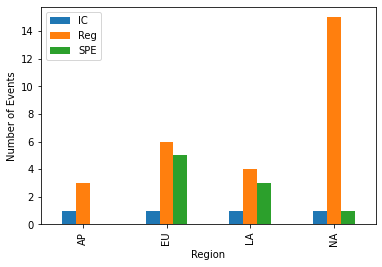

In [37]:
events_totals.plot(kind='bar');
plt.legend();
plt.ylabel('Number of Events');

In [38]:
standings_melted = final_standings.melt(id_vars='Player_Name', var_name='Event', value_name='Points', ignore_index=True)

player_results = pd.merge(standings_melted, events, on='Event', how='inner')

local_info = pd.DataFrame()

for player in final_standings['Player_Name']:
    player_info = final_standings.loc[final_standings['Player_Name'] == player, ['Player_Name', 'Local_Events_CP']]
    player_info.rename(columns={'Local_Events_CP' : 'Points'}, inplace=True)
    player_info['Event']='Locals'
    player_info['Date']='2023-06-30'
    player_info['Date']=pd.to_datetime(player_info['Date'])
    player_info['Region']='LO'
    player_info['Type of Event']='Locals'
    local_info = local_info.append(player_info)

new_player_results = pd.concat([player_results, local_info])

new_player_results = new_player_results.sort_values(by=['Player_Name', 'Date'])

new_player_results['Points'] = pd.to_numeric(new_player_results['Points'])


new_player_results['Total Points']=new_player_results.groupby('Player_Name')['Points'].cumsum()

new_player_results.dropna(inplace=True)

new_player_results['Total Points'] = new_player_results.groupby('Player_Name')['Total Points'].fillna(method='ffill')




In [39]:
new_player_results[new_player_results['Player_Name']=='MikeFouchet']


,Player_Name,Event,Points,Date,Region,Type of Event,Total Points
587264,MikeFouchet,baltimore,50.0,2022-09-16,NA,Reg,50.0
73140,MikeFouchet,toronto,30.0,2022-12-02,NA,Reg,80.0
389524,MikeFouchet,arlington,40.0,2022-12-16,NA,Reg,120.0
369750,MikeFouchet,orlando,0.0,2023-02-03,NA,Reg,120.0
785004,MikeFouchet,EUIC,0.0,2023-04-14,EU,IC,120.0
705908,MikeFouchet,hartford,50.0,2023-05-19,NA,Reg,170.0
429072,MikeFouchet,milwaukee,50.0,2023-06-02,NA,Reg,220.0
765230,MikeFouchet,NAIC,60.0,2023-06-30,NA,IC,280.0
13818,MikeFouchet,Locals,120.0,2023-06-30,LO,Locals,400.0


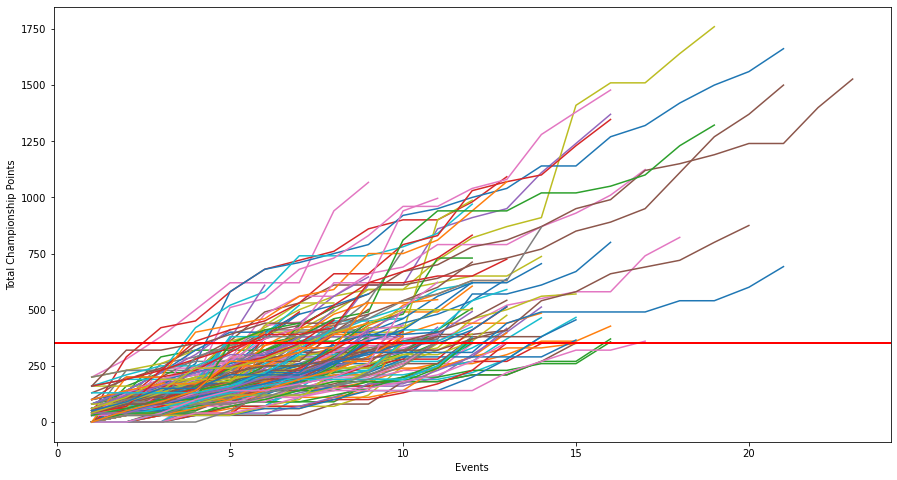

In [41]:
plt.figure(figsize=(15, 8))
NA_invitees = CP_standings['name'][(CP_standings['region']=='NA') & (CP_standings['points']>=350)]
NA_invitees = new_player_results[new_player_results['Player_Name'].isin(NA_invitees)]
NA_invitees = NA_invitees[NA_invitees['Player_Name']!='DarinOMeara']
player_dfs = {}  # create a dictionary to store dataframes

for player in NA_invitees['Player_Name'].unique(): 
    player_df = new_player_results[new_player_results['Player_Name'] == player].copy()
    player_df['Event_Number'] = [x for x in range (1, len(player_df)+1)] 
    player_dfs[player] = player_df  # store dataframe in dictionary with player's name as key
    plt.plot(player_df['Event_Number'] , player_df['Total Points'])
    plt.axhline(y = 350, color = 'r', linestyle = '-')

    

plt.xlabel('Events')
plt.ylabel('Total Championship Points')
plt.show()
#num_EU_invites = CP_standings['name'][(CP_standings['region']=='EU') & (CP_standings['points']>=250)].count()
#num_LA_invites = CP_standings['name'][(CP_standings['region']=='LA') & (CP_standings['points']>=250)].count()
#num_AP_invites = CP_standings['name'][(CP_standings['region']=='AP') & (CP_standings['points']>=200)].count()

In [47]:
len(pd.unique(NA_invitees['Player_Name']))

162

In [ ]:
NA_invitees.sort_values(by='Total Points', ascending=False)

In [48]:
mike = player_results[player_results['Player_Name']=='MikeFouchet']
ross = player_results[player_results['Player_Name']=='RossCawthon']
tord = player_results[player_results['Player_Name']=='TordReklev']
mike = mike.copy()
mike['Event_Number']=[x for x in range (1, len(mike)+1)]
ross = ross.copy()
ross['Event_Number']=[x for x in range (1, len(ross)+1)]
tord=tord.copy()
tord['Event_Number']=[x for x in range (1, len(tord)+1)]


In [49]:
plt.figure(figsize=(len(mike.index)*2, len(mike.index)/1.5))
plt.plot(mike['Event_Number'] , mike['Total Points'])
plt.plot(ross['Event_Number'] , ross['Total Points'])
plt.plot(tord['Event_Number'] , tord['Total Points'])
plt.xlabel('Events')
plt.ylabel('Total Championship Points')
plt.show()

KeyError: 'Total Points'

<Figure size 5760x1920 with 0 Axes>

In [ ]:
final_standings_test=ICs_regionals_spes


In [ ]:
sns.scatterplot(y=final_standings_test['Regs_BFL_CP'], x=final_standings_test['number_regs_played'])

In [ ]:
final_standings.shape

In [ ]:
#np.sort(final_standings_test['number_regs_played'].unique())
player_count_per_reg=final_standings_test[['Player_Name', 'number_regs_played']].groupby('number_regs_played').count()
#points_per_reg['Average_Regs_CP']=points_per_reg['Regs_CP']/points_per_reg.index

points_per_reg=final_standings_test[['Regs_CP', 'Regs_BFL_CP', 'number_regs_played']].groupby('number_regs_played').sum()

test = pd.merge(player_count_per_reg, points_per_reg, left_index=True, right_index=True)
test['Average_Regs_CP']=test['Regs_CP']/test['Player_Name']
test

In [ ]:
final_standings_test[['Player_Name','Regs_CP', 'Regs_BFL_CP', 'number_regs_played']][final_standings_test['number_regs_played']==18]


In [ ]:
player_results.to_excel('player_results.xlsx', index=False)


In [ ]:
player_results[player_results['Event']=='lille']

In [ ]:
#Relevant Dataframes
summary_results
tourney_results
final_standings
player_results
region_info

final_standings.to_excel('final_standings.xlsx', index=False)
player_results.to_excel('player_results.xlsx', index=False)
region_info.to_excel('region_info.xlsx', index=False)
summary_results.to_excel('player_summary.xlsx', index=False)